# Centerless grinding data preprocessing

Preprocessing is a crucial step in any data science project, ensuring that the dataset is clean, structured, and suitable for predictive modeling. This phase involves transforming raw data into a format that enhances the performance and reliability of machine learning algorithms. The preprocessing workflow follows a systematic approach:

**Handling Missing Values**
- Identification of missing data patterns and their implications on the dataset
- Selection of an appropriate imputation strategy (e.g., mean, median, mode, interpolation, model-based imputation)
- Evaluation of whether missing data should be removed or retained based on its impact

**Data Cleaning**
- Removal of duplicate entries to ensure data integrity
- Correction of inconsistencies and errors in categorical and numerical data
- Handling of erroneous or irrelevant values that might affect model performance

**Feature Engineering**
- Creation of new relevant features to enhance predictive power
- Transformation of existing features to improve their interpretability (e.g., logarithmic transformation, polynomial features, binning)
- Encoding categorical variables into numerical representations (e.g., one-hot encoding, label encoding, target encoding)

**Feature Selection**
- Variance thresholding to remove low-variance features
- Correlation analysis to eliminate redundant features
- Statistical tests (e.g., mutual information, chi-square test) to select the most informative features

**Feature Scaling and Normalization**
- Standardization (Z-score normalization) to ensure features have a mean of 0 and standard deviation of 1
- Min-max scaling to map features within a specific range (e.g., [0,1])
- Log transformations to handle skewed distributions

**Data Splitting**
- Partitioning the dataset into training, validation, and test sets to evaluate model performance
- Consideration of stratified sampling for imbalanced datasets
- Implementation of cross-validation techniques to enhance model generalization

This preprocessing phase lays the groundwork for efficient and effective model training, ensuring that data-related issues are addressed before proceeding to modeling. A well-preprocessed dataset leads to better model accuracy, reliability, and interpretability.




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.io as sio
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

## Loading data

In [3]:
df_comp = pd.read_csv('CenterlessGrindingData.csv')
df_comp  = df_comp.drop(df_comp.columns[0], axis=1)
df_comp.head()

,wp_height,blade_angle,feed_vel,tot_diam_remov,wp_lenght,wp_diameter,grind_wheel_diam,contr_wheel_diam,contr_wheel_vel,grind_spec_energy,edge_force_comp,grit_stiff,Hi_fidelity_output
0,6.294556,40.0,0.023139,18.0,49.151611,6.953735,334.106445,222.247314,16.145020,34810.791016,4.900513,384.521484,3.139700
1,12.056274,20.0,0.009617,13.0,117.293701,15.023804,308.862305,255.902100,20.334473,36568.603516,0.848999,289.208984,4.364352
2,-3.568726,40.0,0.014660,10.0,29.759521,45.276489,372.875977,263.262939,26.179199,36370.849609,2.658081,485.595703,3.438761
3,1.356812,20.0,0.013362,13.0,42.962646,39.072876,499.243164,334.197998,28.937988,18924.560547,4.026489,310.986328,1.716082
4,15.718384,30.0,0.014401,6.0,86.126709,46.323853,488.256836,214.007568,19.172363,16456.298828,1.771851,206.689453,5.781276


In [4]:
df_comp.describe()

,wp_height,blade_angle,feed_vel,tot_diam_remov,wp_lenght,wp_diameter,grind_wheel_diam,contr_wheel_diam,contr_wheel_vel,grind_spec_energy,edge_force_comp,grit_stiff,Hi_fidelity_output
count,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000
mean,7.500000,28.000488,0.013500,29.997314,85.000000,32.500000,400.000000,275.000000,20.000000,25000.000000,2.500000,400.000000,8.553068
std,7.217759,7.483380,0.006640,29.602449,37.532348,15.879070,57.742074,43.306556,5.774207,8661.311133,1.443552,115.484148,7.750870
min,-4.996948,20.000000,0.002003,2.000000,20.015869,5.006714,300.024414,200.018311,10.002441,10003.662109,0.000610,200.048828,0.074228
25%,1.251526,20.000000,0.007751,12.000000,52.507935,18.753357,350.012207,237.509155,15.001221,17501.831055,1.250305,300.024414,3.880525
50%,7.500000,30.000000,0.013500,20.000000,85.000000,32.500000,400.000000,275.000000,20.000000,25000.000000,2.500000,400.000000,6.987628
75%,13.748474,30.000000,0.019249,36.000000,117.492065,46.246643,449.987793,312.490845,24.998779,32498.168945,3.749695,499.975586,11.357380
max,19.996948,40.000000,0.024997,233.000000,149.984131,59.993286,499.975586,349.981689,29.997559,39996.337891,4.999390,599.951172,247.346615


## Handling missing values & Data Cleaning
- Identification of missing data patterns and their implications on the dataset
- Selection of an appropriate imputation strategy (e.g., mean, median, mode, interpolation, model-based imputation)
- Evaluation of whether missing data should be removed or retained based on its impact
- Removal of duplicate entries to ensure data integrity
- Correction of inconsistencies and errors in categorical and numerical data
- Handling of erroneous or irrelevant values that might affect model performance

However, the nature of our dataset presents a unique situation. Since the data were generated using a high-fidelity mathematical model of the centerless grinding process, we benefit from several inherent data quality guarantees:

- Completeness: The synthetic data generation process ensures no missing values in any feature.
- Uniqueness: The controlled generation environment eliminates the possibility of duplicate records.
- Validity: All data points represent physically valid process states, as they were generated by a validated mathematical model.
- Consistency: The model-based generation ensures internal consistency across all variables.

This high level of data quality, inherent to synthetic datasets generated from validated mathematical models, allows us to proceed directly to the feature engineering phase without the need for traditional cleaning operations.

In [5]:
df = df_comp.copy() # make a copy of the original dataset

In [6]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # Shuffle the data

In [7]:
# Split the data into X and y
X = df.drop('Hi_fidelity_output', axis=1)
y = df['Hi_fidelity_output']

## Feature Engineering
- Creation of new relevant features to enhance predictive power
- Transformation of existing features to improve their interpretability (e.g., logarithmic transformation, polynomial features, binning)
- Encoding categorical variables into numerical representations (e.g., one-hot encoding, label encoding, target encoding)

In [8]:
numerical_features = df.select_dtypes(include=[np.number]).columns
skewed_features = df[numerical_features].apply(lambda x: np.round(x.skew(), 3)).sort_values(ascending=False)
skewed_features = pd.DataFrame({'Skewness': skewed_features})
skewed_features

,Skewness
Hi_fidelity_output,9.003
tot_diam_remov,2.463
blade_angle,0.344
wp_height,0.000
feed_vel,0.000
wp_lenght,0.000
wp_diameter,-0.000
grind_wheel_diam,0.000
contr_wheel_diam,-0.000
contr_wheel_vel,0.000


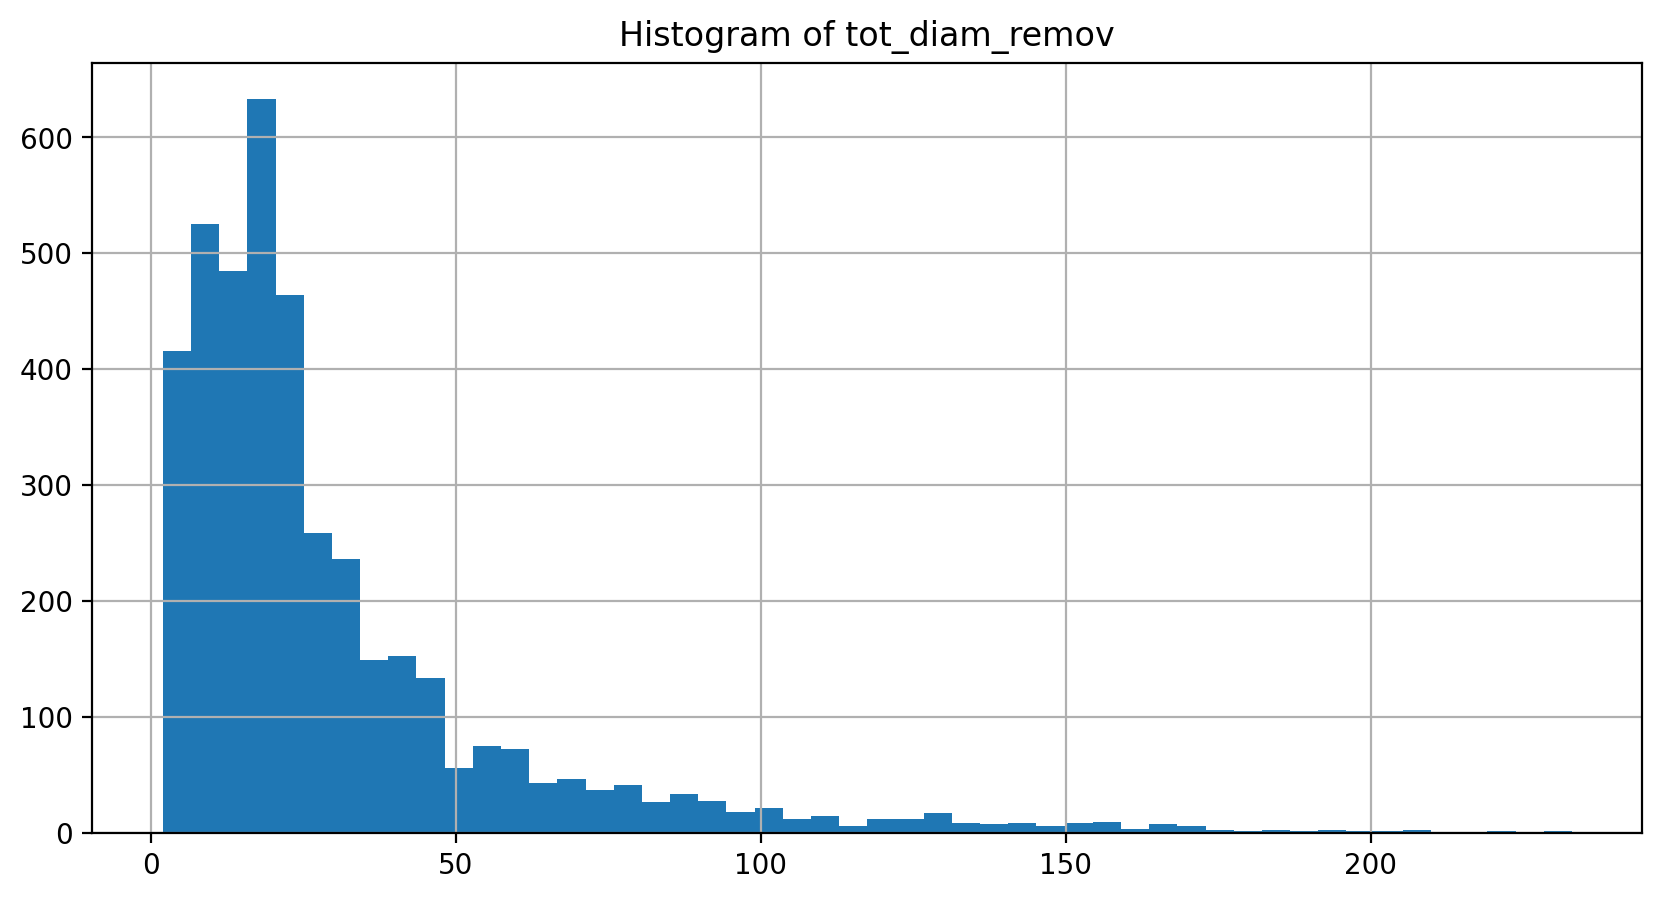

In [9]:
df.tot_diam_remov.hist(bins=50, figsize=(10,5))
plt.title("Histogram of tot_diam_remov")
plt.show()

In [10]:
skewed_features_index = skewed_features[(skewed_features.Skewness > 0.75) & (skewed_features.index != "Hi_fidelity_output")].index
df[skewed_features_index] = np.log1p(df[skewed_features_index])

In [11]:
numerical_features = df.select_dtypes(include=[np.number]).columns
skewed_features = df[numerical_features].apply(lambda x: np.round(x.skew(), 3)).sort_values(ascending=False)
skewed_features = pd.DataFrame({'Skewness': skewed_features})
skewed_features[skewed_features.index == "tot_diam_remov"]

,Skewness
tot_diam_remov,0.147


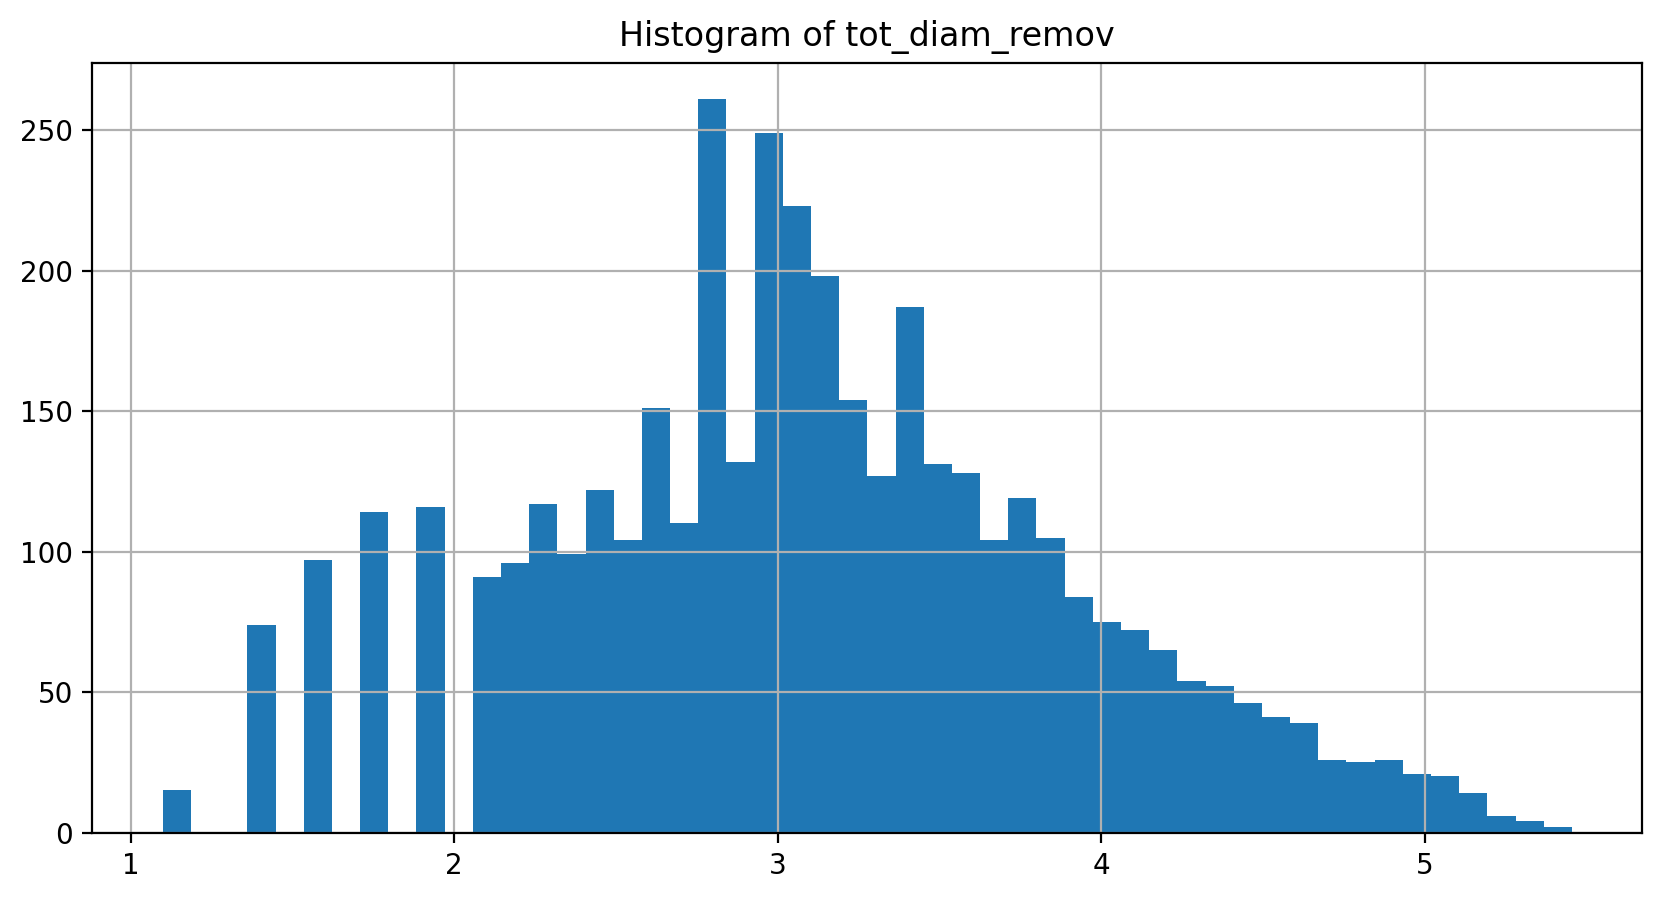

In [12]:
df.tot_diam_remov.hist(bins=50, figsize=(10,5))
plt.title("Histogram of tot_diam_remov")
plt.show()

The data inspection phase revealed significant asymmetry in two key variables: the target variable and the total diameter removal feature, exhibiting skewness values of 9.0 and 2.4 respectively. This asymmetric distribution pattern poses potential challenges for modeling, particularly for algorithms that assume underlying data symmetry.
To mitigate this issue, a log1p transformation (natural logarithm of x + 1) was applied to the total diameter removal feature. This mathematical transformation was selected for its effectiveness in reducing distributional skewness while preserving the relative relationships between data points. The transformation successfully normalized the feature's distribution, making it more suitable for subsequent modeling phases.
While the target variable displays an even more pronounced skewness, the decision was made to maintain its original scale. This deliberate choice represents a trade-off between statistical optimization and practical utility. Preserving the target variable in its original form ensures that model predictions can be directly interpreted in terms of actual roundness measurements, enhancing the model's practical applicability in manufacturing settings. This prioritization of interpretability over perfect statistical properties aligns with the project's objective of creating a practically useful tool for process optimization.

## Feature Selection
- Variance thresholding to remove low-variance features
- Correlation analysis to eliminate redundant features
- Statistical tests (e.g., mutual information, chi-square test) to select the most informative features

The initial feature selection phase employed filter methods exclusively to reduce input space dimensionality. This preliminary approach was chosen for its computational efficiency and model-agnostic nature. However, the feature selection strategy may be expanded during the model selection phase through an iterative process that could incorporate:

- wrapper methods: to evaluate feature subsets using the target models themselves
- embedded methods: to perform feature selection as part of the model training process
- dimensionality reduction techniques: such as Principal Component Analysis (PCA), if the complexity of feature interactions warrants a transformation approach

This staged approach to feature selection allows for initial dimensionality reduction while maintaining the flexibility to implement more sophisticated methods based on model performance feedback and computational requirements.

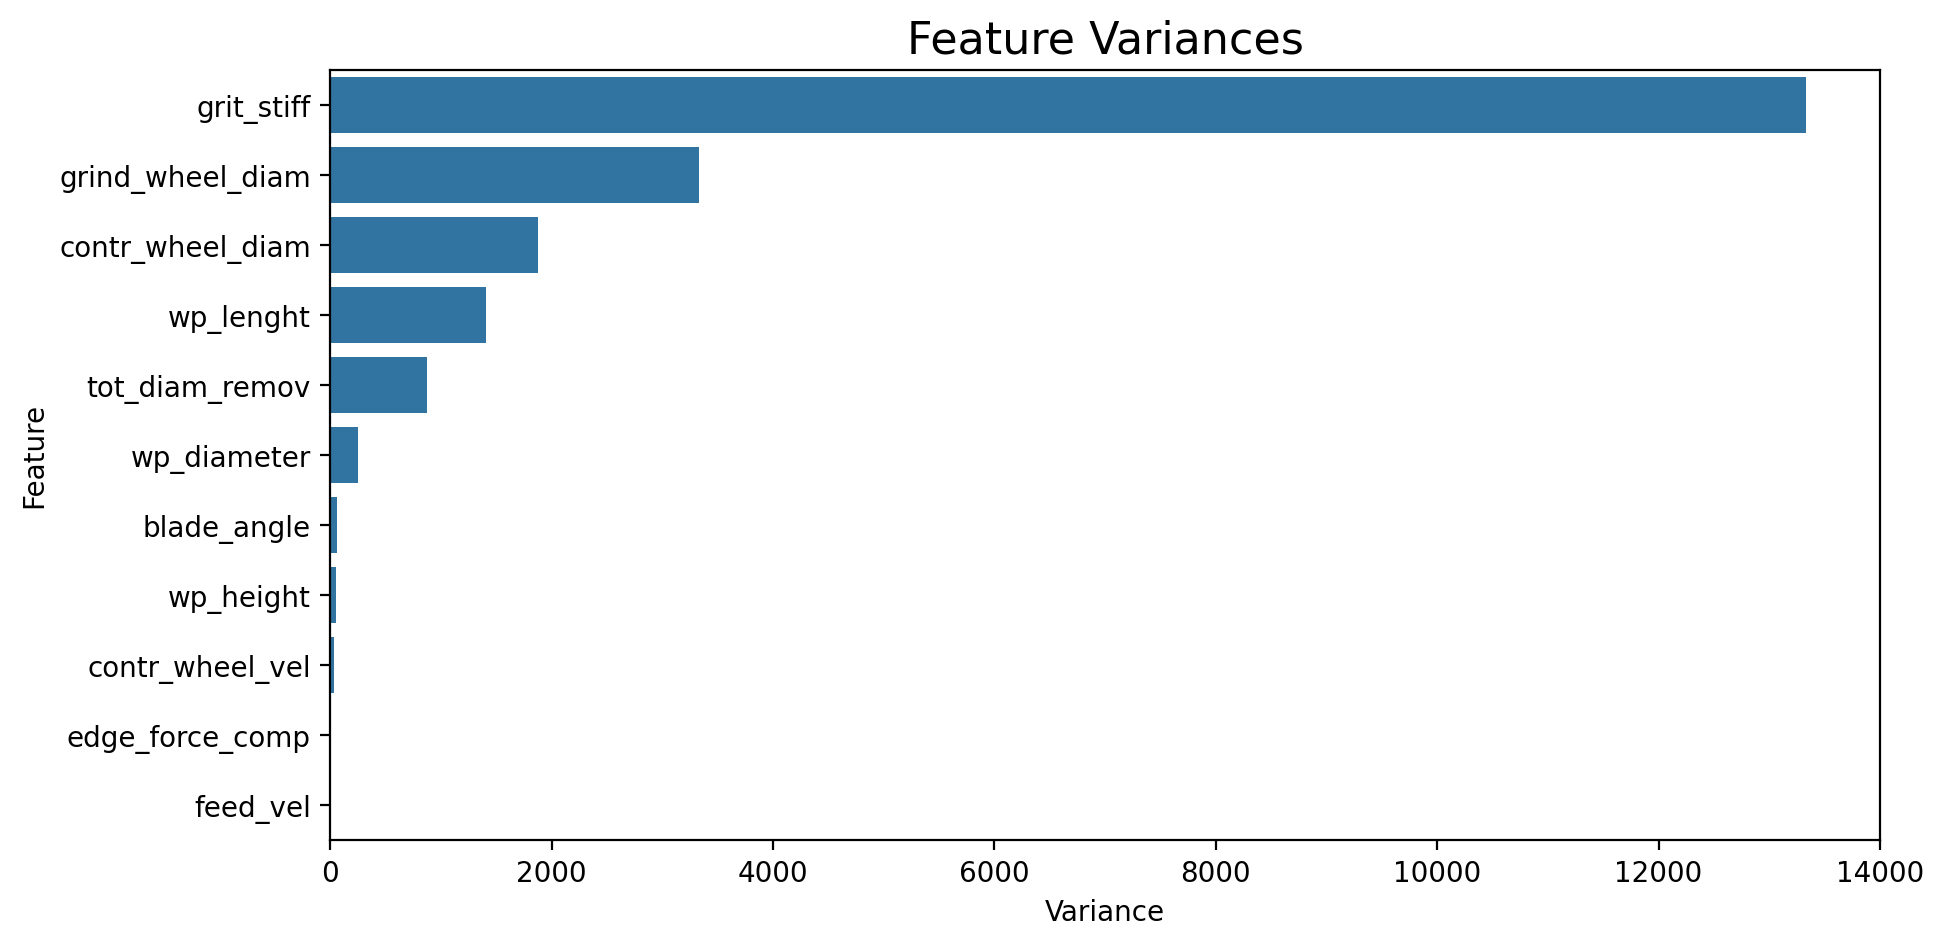

In [13]:
feature_variances = pd.DataFrame({'Feature': X.columns, 'Variance': X.var()})
feature_variances = feature_variances.sort_values(by='Variance', ascending=False)
feature_variances.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(x='Variance', y=feature_variances.index[feature_variances.index != "grind_spec_energy"], data=feature_variances[feature_variances.index != "grind_spec_energy"]) # grind_spec_energy has a very high variance
plt.title('Feature Variances', fontsize=16)
plt.xlabel('Variance')
plt.ylabel('Feature')
plt.show()

In [14]:
threshold = X.var().quantile(0.05)
feature_selection_variance_model = VarianceThreshold(threshold=threshold)
X_selected_features_variance = feature_selection_variance_model.fit_transform(X)

mask = feature_selection_variance_model.get_support() #list of booleans
print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", X.columns[mask].tolist())
print("      Deleted Features = ", X.columns[~mask].tolist())

Reduced data set shape =  (4096, 11)
     Selected features =  ['wp_height', 'blade_angle', 'tot_diam_remov', 'wp_lenght', 'wp_diameter', 'grind_wheel_diam', 'contr_wheel_diam', 'contr_wheel_vel', 'grind_spec_energy', 'edge_force_comp', 'grit_stiff']
      Deleted Features =  ['feed_vel']


In [15]:
mi_scores = mutual_info_regression(X, y) # Compute the mutual information between each feature and the target
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)

X_reduced = X.loc[:, mi_scores > 0.01] # Select the features with MI score greater than 0.01

print("Reduced data set shape = ", X_reduced.columns.tolist())

Reduced data set shape =  ['wp_height', 'tot_diam_remov', 'wp_lenght', 'wp_diameter', 'contr_wheel_vel', 'edge_force_comp']


The feature selection phase employed two complementary filter-based approaches: variance threshold and mutual information analysis.

**Variance Threshold Analysis**

The variance threshold method operates on the principle that features with low variance contribute less discriminative information to the model (the threshold was set at the 5th percentile of the variance distribution). This analysis, combined with correlation findings from the data inspection phase, initially highlighted the feed velocity feature as a candidate for removal due to its:

- High negative correlation with total diameter rate
- Redundancy in information content
- Relatively low contribution to overall data variance

However, despite these statistical indicators suggesting its removal, the feed velocity was retained in the feature set due to its fundamental importance in the centerless grinding process. Domain expertise indicates that feed velocity is a critical control parameter that directly influences the material removal rate and final workpiece quality.

**Mutual Information Assessment**

The mutual information (MI) analysis provided a more sophisticated evaluation of feature relevance by quantifying the statistical dependency between each feature and the target variable. This method:

- measures the information content shared between features and the target
- provides scores ranging from 0 (complete independence) to higher values indicating stronger relationships
- identifies features with minimal contribution to target prediction

While the mutual information analysis suggested the possibility of removing additional features, a conservative approach was adopted given the moderate dimensionality of the input space. 
This conservative strategy maintains maximum information content while eliminating clear redundancy, with the flexibility to implement more aggressive feature reduction in subsequent iterations if model performance indicates its necessity.

## Feature Scaling and Normalization
- Standardization (Z-score normalization) to ensure features have a mean of 0 and standard deviation of 1
- Min-max scaling to map features within a specific range (e.g., [0,1])
- Log transformations to handle skewed distributions

In [16]:
scaler = StandardScaler()

X_norm = scaler.fit_transform(X) # Normalizing the data
y_norm = scaler.fit_transform(y.values.reshape(-1,1)).flatten()
X_norm = pd.DataFrame(X_norm, columns=X.columns)
y_norm = pd.Series(y_norm, name='Hi_fidelity_output')
df_preprocessed = pd.concat([X_norm, y_norm], axis=1)

# Saving the data

In [17]:
df_preprocessed.to_csv('CenterlessGrindingDataPreprocessed.csv')

The hold-out procedure will be implemented in the model selection & evaluation notebook.